In [3]:
%load_ext autoreload
%autoreload 2

In [28]:
import albumentations as A
import open_clip
import torch
from PIL import Image
import numpy as np
import sys
sys.path.append("../tools")
from utils import plot_tensor, plot_pil_img, plot_np_array

In [4]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
	A.OneOf([
    A.ImageCompression(quality_lower=40,quality_upper=40,p=1/3),
    A.ImageCompression(quality_lower=65,quality_upper=65,p=1/3),
	A.ImageCompression(quality_lower=90,quality_upper=90,p=1/3),
    ], p=3/4)
    ], p=1.0)

device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('hf-hub:laion/CLIP-ViT-L-14-DataComp.XL-s13B-b90K',device=device)

In [15]:
img = Image.open("../../img/cat.png")

In [16]:
preprocess(img).shape

torch.Size([3, 224, 224])

In [17]:
transform(image=np.array(img.convert("RGB")))

{'image': array([[[ 43,  90,  41],
         [ 43,  90,  41],
         [ 43,  90,  41],
         ...,
         [ 43,  67,  43],
         [ 40,  61,  39],
         [ 32,  48,  31]],
 
        [[ 43,  90,  41],
         [ 43,  90,  41],
         [ 43,  90,  41],
         ...,
         [ 42,  66,  42],
         [ 39,  60,  38],
         [ 31,  47,  30]],
 
        [[ 44,  91,  42],
         [ 44,  91,  42],
         [ 44,  91,  42],
         ...,
         [ 41,  65,  41],
         [ 38,  59,  37],
         [ 30,  46,  29]],
 
        ...,
 
        [[ 71, 136,  51],
         [ 71, 136,  51],
         [ 71, 136,  51],
         ...,
         [ 99,  39,  15],
         [ 99,  59,  40],
         [ 40,  26,  14]],
 
        [[ 70, 135,  50],
         [ 70, 135,  50],
         [ 70, 135,  50],
         ...,
         [136,  76,  52],
         [123,  81,  62],
         [ 47,  31,  19]],
 
        [[ 70, 135,  50],
         [ 70, 135,  50],
         [ 70, 135,  50],
         ...,
         [158,  96,

In [32]:
pre = preprocess(Image.fromarray(transform(image=np.array(img.convert("RGB")))["image"]))
pre.shape

torch.Size([3, 224, 224])

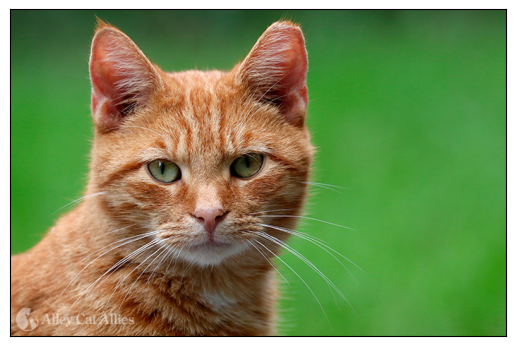

In [33]:
plot_pil_img(img)

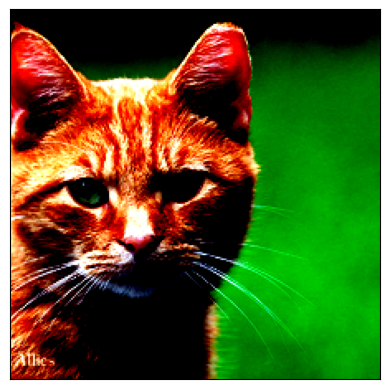

In [34]:
plot_tensor(preprocess(img))

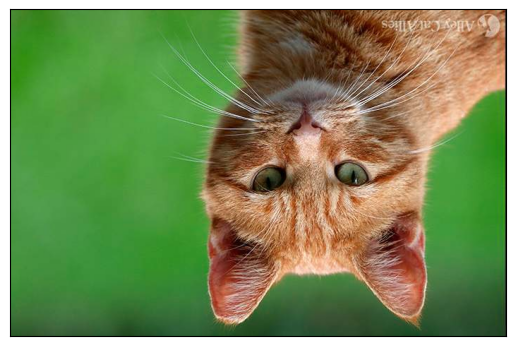

In [35]:
plot_np_array(transform(image=np.array(img.convert("RGB")))["image"])

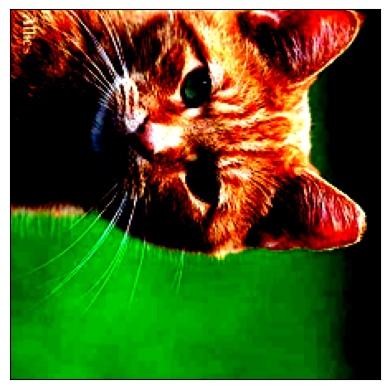

In [36]:
plot_tensor(pre)

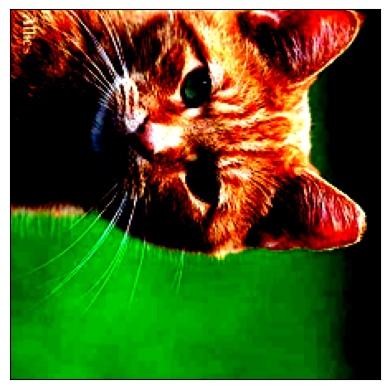

In [50]:
from torchvision.transforms import ToPILImage

plot_pil_img(pre.permute(1,2,0).numpy())

In [59]:
np.array(img)[:,:,:3]

array([[[ 35,  35,  35],
        [ 34,  69,  39],
        [ 32,  69,  38],
        ...,
        [ 40,  90,  39],
        [ 40,  90,  39],
        [ 43,  91,  41]],

       [[ 34,  34,  34],
        [ 27,  66,  35],
        [ 27,  66,  35],
        ...,
        [ 41,  91,  40],
        [ 42,  92,  41],
        [ 42,  92,  41]],

       [[ 33,  33,  33],
        [ 28,  67,  36],
        [ 29,  68,  37],
        ...,
        [ 44,  92,  42],
        [ 43,  93,  42],
        [ 43,  93,  42]],

       ...,

       [[ 34,  34,  34],
        [122,  53,  14],
        [116,  48,   9],
        ...,
        [ 72, 138,  50],
        [ 72, 138,  50],
        [ 69, 138,  47]],

       [[ 34,  34,  34],
        [139,  75,  37],
        [139,  75,  37],
        ...,
        [ 70, 136,  48],
        [ 70, 136,  48],
        [ 70, 136,  48]],

       [[ 35,  35,  35],
        [158, 100,  62],
        [159, 103,  66],
        ...,
        [ 70, 136,  48],
        [ 70, 134,  48],
        [ 69, 135,  48]]